# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import authentic_performance as ap
from scipy.stats import uniform, norm
import networkx as nx
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch, os
from sklearn.model_selection import train_test_split
import torch_geometric.utils as utils
from torch.utils.data import DataLoader
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
import pickle
import shutil

In [3]:
def power_law(x, a=1):
    return (1/x)**a

# GLOBAL VARIABLES FOR ALL DATASETS
LEN_TRAIN_DATASET = 100
LEN_TEST_DATASET = 100
LIST_FRAUD_PROBABILITIES = [round(x,2) for x in list(np.linspace(0,1,11))]
N = 100
P = 10/N
DISTRIBUTION = uniform
DECREASING_FUNCTION = lambda x : power_law(x, 3)
FRAUDSTER_INDEX = round(N/2)
ITERATIONS = 1000

In [58]:
def clean_dataDirectory():
    root = "data/synthetic-dataset/"
    for dir_net in list(os.walk(root))[0][1]:
        dir_datasets = (list(os.walk(os.path.join(root, dir_net)))[0][1])
        for dataset in dir_datasets:
            dataset_path = os.path.join(root, dir_net, dataset)
            print("Cleaning :", dataset_path)
            for file in list(os.walk(dataset_path))[0][2]:
                os.remove(os.path.join(dataset_path, file))
            shutil.rmtree(dataset_path)

def create_dataDirectoryArchitecture():
    for d in list(os.walk('data/synthetic-dataset/'))[0][1]:
        if "no-fraudster" in d:
            os.mkdir(os.path.join('data/synthetic-dataset/', d, 'train'))
        os.mkdir(os.path.join('data/synthetic-dataset/', d, 'test'))
        if d not in ['random-net-no-fraudster', "fitted-net-no-fraudster"]:
            for proba in LIST_FRAUD_PROBABILITIES:
                os.mkdir(os.path.join('data/synthetic-dataset/', d, 'test', str(proba)))
                
def visualize_network(path):
    with open(path, "rb") as f:
        G = pickle.load(f)
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    nx.draw_networkx(G, node_size=np.array(list(dict(G.in_degree()).values()))*10, width=0.33, font_size=6)
    plt.title("Node size : in-degree")
    plt.subplot(132)
    plt.title("Node size : degree")
    nx.draw_networkx(G, node_size=np.array(list(dict(G.degree()).values()))*10, width=0.33, font_size=6)
    plt.subplot(133)
    plt.title("Ego network")
    nx.draw_networkx(nx.ego_graph(G, FRAUDSTER_INDEX, undirected=True), width=0.33)

clean_dataDirectory()
create_dataDirectoryArchitecture()

Cleaning : data/synthetic-dataset/strength-net-malicious-fraudster/test
Cleaning : data/synthetic-dataset/strength-net-no-fraudster/train
Cleaning : data/synthetic-dataset/strength-net-no-fraudster/test
Cleaning : data/synthetic-dataset/random-net-malicious-fraudster/test
Cleaning : data/synthetic-dataset/random-net-no-fraudster/train
Cleaning : data/synthetic-dataset/random-net-no-fraudster/test
Cleaning : data/synthetic-dataset/fitted-net-no-fraudster/train
Cleaning : data/synthetic-dataset/fitted-net-no-fraudster/test
Cleaning : data/synthetic-dataset/random-net-dumb-fraudster/test
Cleaning : data/synthetic-dataset/strength-net-dumb-fraudster/test


# Dataset creation

In [67]:
# random-net-no-fraudster

def generate_graph():
    return ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=False,
                        fraudster_index=None,
                        fraudster_strength=None,
                        fraud_probability=None,
                        strength_scheme=False,
                        iterations=0,
                        decreasing_function=None,
                        fraud_scheme=None)

for i in range(LEN_TRAIN_DATASET):
    G = generate_graph()
    with open(f'data/synthetic-dataset/random-net-no-fraudster/train/G_{i}.pickle', "wb") as f:
        pickle.dump(G, f)

for i in range(LEN_TEST_DATASET):
    G = generate_graph()
    with open(f'data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle', "wb") as f:
        pickle.dump(G, f)

del generate_graph

In [68]:
# random-net-dumb-fraudster

def generate_graph(fraud_probability):
    return ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=True,
                        fraudster_index=FRAUDSTER_INDEX,
                        fraudster_strength=None,
                        fraud_probability=fraud_probability,
                        strength_scheme=False,
                        iterations=0,
                        decreasing_function=None,
                        fraud_scheme=None)
    
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    for i in range(LEN_TEST_DATASET):
        G = generate_graph(fraud_proba)
        with open(f'data/synthetic-dataset/random-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle', "wb") as f:
            pickle.dump(G, f)

del generate_graph

In [ ]:
# random-net-malicious-fraudster

def generate_graph(fraud_probability):
    return ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=True,
                        fraudster_index=FRAUDSTER_INDEX,
                        fraudster_strength=None,
                        fraud_probability=fraud_probability,
                        strength_scheme=False,
                        iterations=0,
                        decreasing_function=DECREASING_FUNCTION,
                        fraud_scheme="strength")
    
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    for i in range(LEN_TEST_DATASET):
        G = generate_graph(fraud_proba)
        with open(f'data/synthetic-dataset/random-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle', "wb") as f:
            pickle.dump(G, f)

del generate_graph

In [8]:
# strength-net-no-fraudster
def generate_graph():
    return ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=False,
                        fraudster_index=None,
                        fraudster_strength=None,
                        fraud_probability=None,
                        strength_scheme=True,
                        iterations=ITERATIONS,
                        decreasing_function=DECREASING_FUNCTION,
                        fraud_scheme=None)
    
for i in range(LEN_TRAIN_DATASET):
    G = generate_graph()
    with open(f'data/synthetic-dataset/strength-net-no-fraudster/train/G_{i}.pickle', "wb") as f:
        pickle.dump(G, f)
for i in range(LEN_TEST_DATASET):
    G = generate_graph()
    with open(f'data/synthetic-dataset/strength-net-no-fraudster/test/G_{i}.pickle', "wb") as f:
        pickle.dump(G, f)

del generate_graph

In [9]:
# strength-net-dumb-fraudster

def generate_graph(fraud_probability):
    return ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=True,
                        fraudster_index=FRAUDSTER_INDEX,
                        fraudster_strength=None,
                        fraud_probability=fraud_probability,
                        strength_scheme=True,
                        iterations=ITERATIONS,
                        decreasing_function=DECREASING_FUNCTION,
                        fraud_scheme=None)

for fraud_proba in LIST_FRAUD_PROBABILITIES:
    for i in range(LEN_TEST_DATASET):
        G = generate_graph(fraud_proba)
        with open(f'data/synthetic-dataset/strength-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle', "wb") as f:
            pickle.dump(G, f)

del generate_graph

In [10]:
# strength-net-malicious-fraudster

def generate_graph(fraud_probability):
    return ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=True,
                        fraudster_index=FRAUDSTER_INDEX,
                        fraudster_strength=None,
                        fraud_probability=fraud_probability,
                        strength_scheme=True,
                        iterations=ITERATIONS,
                        decreasing_function=DECREASING_FUNCTION,
                        fraud_scheme="strength")
    
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    for i in range(LEN_TEST_DATASET):
        G = generate_graph(fraud_proba)
        with open(f'data/synthetic-dataset/strength-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle', "wb") as f:
            pickle.dump(G, f)

del generate_graph

In [65]:
# fitted-net-no-fraudster

def generate_graph():
    return ap.generate_fittedUFCNetwork(N, alpha=1/3)

for i in range(LEN_TRAIN_DATASET):
    G = generate_graph()
    with open(f'data/synthetic-dataset/fitted-net-no-fraudster/train/G_{i}.pickle', "wb") as f:
        pickle.dump(G, f)
for i in range(LEN_TEST_DATASET):
    G = generate_graph()
    with open(f'data/synthetic-dataset/fitted-net-no-fraudster/test/G_{i}.pickle', "wb") as f:
        pickle.dump(G, f)

del generate_graph

# Staging

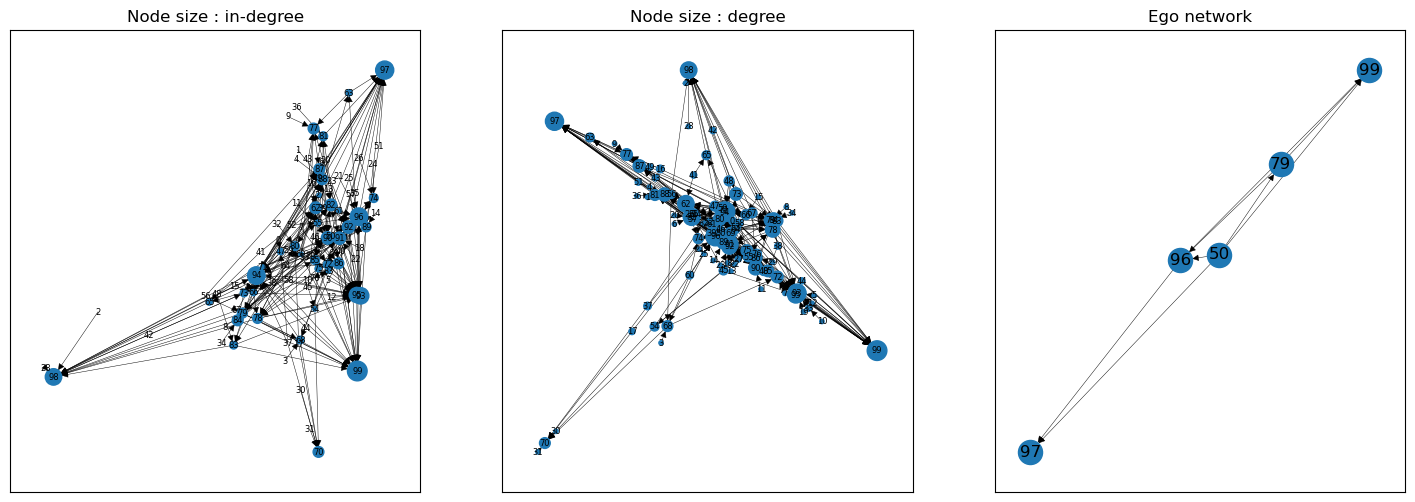

In [66]:
visualize_network(f'data/synthetic-dataset/fitted-net-no-fraudster/test/G_{99}.pickle')

# <>